In [33]:
# Download libraries
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-multilearn
!pip install kagglehub
!git lfs install
!git lfs pull
!pip install plotly
!pip install nba_api
!pip install --upgrade nbformat


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Updated Git hooks.
Git LFS initialized.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ------------------------------------ --- 71.7/78.5 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 78.5/78.5 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/88.5 kB ? eta -:--:--
   ---------------------------------------- 88.5/88.5 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/63.0 kB ? eta -:--:--
   ---------------------------------------- 63.0/63.0 kB ? eta 0:00:00
   ---------------------------------------- 0.0/220.7 kB ? eta -:--:--
   --------------------------------------- 220.7/220.7 kB 14.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing libraries and packages

In [20]:

#  git lfs track "*.csv" 
# git lfs track "notebooks/database.db"

import os
import glob
import kagglehub
import sqlite3
import zipfile
import pandas as pd
from io import BytesIO
#Data Wrangling

import numpy as np
import pandas as pd

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Preprocessing Packages
from sklearn.model_selection import train_test_split

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Model tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Aditonal Data Sources
from nba_api.stats.endpoints import TeamInfoCommon
from nba_api.stats.static import teams

%matplotlib inline

Loading Data Sets

In [21]:
# Path to your zip file
current_dir = os.getcwd()
zip_file_path = current_dir + '/../raw-data/nba-shots.zip'

# list to store dataframes from CSV
csv_dataframes = []

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Loop through each file in the zip
    for file_name in zip_file.namelist():
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            with zip_file.open(file_name) as file:
                df = pd.read_csv(file)
                csv_dataframes.append(df)  # Store the DataFrame in the dictionary

# Now, `csv_dataframes` contains DataFrames for each CSV file
# You can access them by file name, for example:

df = pd.concat(csv_dataframes)
df.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


# Data Dictionary

**Self-Explanatory**: **TEAM_NAME**, **PLAYER_NAME**, **POSITION_GROUP**, **POSITION**, **HOME_TEAM**, **AWAY_TEAM**

- **SEASON_1** & **SEASON_2**: Season indicator variables  
- **TEAM_ID**: NBA's unique ID variable of that specific team in their API  
- **PLAYER_ID**: NBA's unique ID variable of that specific player in their API  
- **GAME_DATE**: Date of the game (M-D-Y // Month-Date-Year)  
- **GAME_ID**: NBA's unique ID variable of that specific game in their API  
- **EVENT_TYPE**: Character variable denoting a shot outcome (Made Shot // Missed Shot)  
- **SHOT_MADE**: True/False variable denoting a shot outcome (True // False)  
- **ACTION_TYPE**: Description of shot type (layup, dunk, jump shot, etc.)  
- **SHOT_TYPE**: Type of shot (2PT or 3PT)  
- **BASIC_ZONE**: Name of the court zone the shot took place in  
  - Restricted Area, In the Paint (non-RA), Midrange, Left Corner 3, Right Corner 3, Above the Break, Backcourt  
- **ZONE_NAME**: Name of the side of court the shot took place in  
  - left, left side center, center, right side center, right  
- **ZONE_ABB**: Abbreviation of the side of court  
  - (L), (LC), (C), (RC), (R)  
- **ZONE_RANGE**: Distance range of shot by zones  
  - Less than 8 ft., 8-16 ft. 16-24 ft. 24+ ft.  
- **LOC_X**: X coordinate of the shot in the x, y plane of the court (0, 50)  
- **LOC_Y**: Y coordinate of the shot in the x, y plane of the court (0, 50)  
- **SHOT_DISTANCE**: Distance of the shot with respect to the center of the hoop, in feet  
- **QUARTER**: Quarter of the game  
- **MINS_LEFT**: Minutes remaining in the quarter  
- **SECS_LEFT**: Seconds remaining in minute of the quarter  


In [22]:
# inspect the Leagues data set
print("Number of duplicate rows: " + str(df.duplicated().sum()))
print("dtypes:")
print(df.dtypes)
print("----------------------------\nLeagues DF describe:")
print(df.describe())
print("----------------------------\nCheck for Null values:")
print(df.isna().sum())
print("----------------------------\nFirst 5 rows of the dataset")
df.head()

Number of duplicate rows: 192
dtypes:
SEASON_1            int64
SEASON_2           object
TEAM_ID             int64
TEAM_NAME          object
PLAYER_ID           int64
PLAYER_NAME        object
POSITION_GROUP     object
POSITION           object
GAME_DATE          object
GAME_ID             int64
HOME_TEAM          object
AWAY_TEAM          object
EVENT_TYPE         object
SHOT_MADE            bool
ACTION_TYPE        object
SHOT_TYPE          object
BASIC_ZONE         object
ZONE_NAME          object
ZONE_ABB           object
ZONE_RANGE         object
LOC_X             float64
LOC_Y             float64
SHOT_DISTANCE       int64
QUARTER             int64
MINS_LEFT           int64
SECS_LEFT           int64
dtype: object
----------------------------
Leagues DF describe:
           SEASON_1       TEAM_ID     PLAYER_ID       GAME_ID         LOC_X  \
count  4.231262e+06  4.231262e+06  4.231262e+06  4.231262e+06  4.231262e+06   
mean   2.014191e+03  1.610613e+09  4.136611e+05  2.131969e+07  9

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


In [23]:
df_clean = df.drop_duplicates()
df_clean.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


In [24]:
#TODO:
print("Number of rows containing NA values:\n" + str(df_clean.isna().sum()[df_clean.isna().sum() > 0]))
df_clean[df_clean["POSITION_GROUP"].isna() | df_clean["POSITION"].isna()]


Number of rows containing NA values:
POSITION_GROUP    7930
POSITION          7930
dtype: int64


,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
596,2013,2012-13,1610612766,Charlotte Bobcats,203106,Jeffery Taylor,NaN,NaN,04-17-2013,21201219,...,Mid-Range,Right Side,R,16-24 ft.,-16.2,12.95,17,4,6,19
900,2013,2012-13,1610612766,Charlotte Bobcats,203106,Jeffery Taylor,NaN,NaN,04-17-2013,21201219,...,Restricted Area,Center,C,Less Than 8 ft.,0.3,5.85,0,3,2,1
1138,2013,2012-13,1610612766,Charlotte Bobcats,203106,Jeffery Taylor,NaN,NaN,04-17-2013,21201219,...,Above the Break 3,Center,C,24+ ft.,-0.0,30.45,25,3,6,42
1688,2013,2012-13,1610612766,Charlotte Bobcats,203106,Jeffery Taylor,NaN,NaN,04-17-2013,21201219,...,Restricted Area,Center,C,Less Than 8 ft.,-0.9,5.95,1,2,7,24
1911,2013,2012-13,1610612766,Charlotte Bobcats,203106,Jeffery Taylor,NaN,NaN,04-17-2013,21201219,...,Mid-Range,Right Side,R,16-24 ft.,-16.8,7.55,16,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210809,2024,2023-24,1610612738,Boston Celtics,1630214,Xavier Tillman,NaN,NaN,04-12-2024,22301173,...,In The Paint (Non-RA),Center,C,8-16 ft.,-4.2,15.25,10,3,0,55
210857,2024,2023-24,1610612738,Boston Celtics,1630214,Xavier Tillman,NaN,NaN,04-14-2024,22301186,...,Right Corner 3,Right Side,R,24+ ft.,-23.3,6.45,23,1,3,15
210859,2024,2023-24,1610612738,Boston Celtics,1630214,Xavier Tillman,NaN,NaN,04-14-2024,22301186,...,Restricted Area,Center,C,Less Than 8 ft.,0.1,8.65,3,1,2,39
210861,2024,2023-24,1610612738,Boston Celtics,1630214,Xavier Tillman,NaN,NaN,04-14-2024,22301186,...,In The Paint (Non-RA),Center,C,Less Than 8 ft.,-4.3,7.45,4,1,1,37


# Global Constants

In [25]:
nba_teams = teams.get_teams()

# Create a dictionary of team IDs
team_ids_dict = {team['full_name']: team['id'] for team in nba_teams}

# Create an empty DataFrame to store the data
df_teams = pd.DataFrame()

# Loop through the teams and append to the df
for team_name, team_id in team_ids_dict.items():
    team_info = TeamInfoCommon(team_id=team_id)
    df_team = team_info.get_data_frames()[0]
    df_team['TeamName'] = team_name  # Adding the team name to the DataFrame
    df_teams = pd.concat([df_teams, df_team], ignore_index=True)


# Print the combined DataFrame
df_teams
# df_teams = df_teams["TEAM_NAME", "TEAM_ABBREVIATION", "TEAM_CITY"]

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [ ]:
# Keep only current NBA teams

In [27]:
conn = sqlite3.connect("database.db")
df_clean.to_sql("nba", conn, if_exists="replace", index=False)


4231070

# Exploratory Data Analysis (EDA)
- Jump Shot accuracy by Zone (2pt and 3pt)
- Accuracy by action type (done)
- Most efficient players + shot distribution heat map
- Home vs. Performance for teams
- Time trend in accuracy, points,  action type, etc
- Accuracy by Position and Zone

# Accuracy by action type

In [ ]:
action_types_p = df_clean.ACTION_TYPE.unique()
action_types_sql = pd.read_sql("SELECT DISTINCT ACTION_TYPE from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(action_types_p) == len(action_types_sql)))
action_types_p

Pandas and SQL versions are identical: True


array(['Jump Shot', 'Driving Layup Shot', 'Dunk Shot',
       'Alley Oop Dunk Shot', 'Fadeaway Jump Shot',
       'Driving Finger Roll Shot', 'Layup Shot', 'Tip Shot',
       'Slam Dunk Shot', 'Running Hook Shot', 'Turnaround Jump Shot',
       'Running Layup Shot', 'Jump Bank Shot', 'Running Jump Shot',
       'Jump Hook Shot', 'Reverse Layup Shot', 'Driving Dunk Shot',
       'Hook Shot', 'Reverse Dunk Shot', 'Running Finger Roll Shot',
       'Turnaround Hook Shot', 'Alley Oop Layup shot',
       'Follow Up Dunk Shot', 'Driving Hook Shot', 'Running Dunk Shot',
       'Finger Roll Shot', 'Hook Bank Shot',
       'Turnaround Finger Roll Shot', 'Running Tip Shot',
       'Turnaround Fadeaway shot', 'Driving Slam Dunk Shot',
       'Step Back Jump shot', 'Pullup Jump shot', 'Running Bank shot',
       'Driving Finger Roll Layup Shot', 'Finger Roll Layup Shot',
       'Pullup Bank shot', 'Putback Dunk Shot', 'Floating Jump shot',
       'Putback Layup Shot', 'Jump Bank Hook Shot',
      

In [ ]:
query = '''
SELECT ACTION_TYPE, COUNT(*) AS count
FROM nba
GROUP BY ACTION_TYPE
ORDER BY count DESC
'''
top_action_types_df = pd.read_sql(query, conn)
# top_action_types_df = df_clean.groupby("ACTION_TYPE").agg(count=("ACTION_TYPE", "count")).sort_values(by="count",  ascending=False).reset_index()
top_action_types_df = top_action_types_df[
    top_action_types_df["count"] >= top_action_types_df["count"].quantile(0.75)].reset_index(drop=True)
action_types_75_p = df_clean[df_clean["ACTION_TYPE"].isin(top_action_types_df["ACTION_TYPE"])][
    ["ACTION_TYPE", "SHOT_MADE", "SHOT_DISTANCE"]]
action_types_75_p = action_types_75_p.groupby("ACTION_TYPE").agg(accuracy=("SHOT_MADE", "mean"),
                                                                 avg_distance=("SHOT_DISTANCE", "mean"),
                                                                 count=("SHOT_MADE", "count")).reset_index()
action_types_75_p

,ACTION_TYPE,accuracy,avg_distance,count
0,Cutting Layup Shot,0.717048,1.701533,42926
1,Driving Finger Roll Layup Shot,0.675188,1.882761,45454
2,Driving Floating Jump Shot,0.432528,7.890536,65894
3,Driving Layup Shot,0.597654,1.508562,288734
4,Dunk Shot,0.870218,0.381341,67837
5,Fadeaway Jump Shot,0.472016,12.970257,64250
6,Floating Jump shot,0.485296,8.303880,58148
7,Hook Shot,0.449582,5.591407,66335
8,Jump Shot,0.345617,20.006034,2002674
9,Layup Shot,0.464173,0.852218,437781


In [ ]:
# Bubble Chart (Scatter Plot with Bubble Size)
# using tuple unpacking for multiple Axes
fig = go.Figure()
fig.update_layout(width=1400, height=800, title="NBA Players Action Type Accuracy, Shot Distance and Attempt Count",
                  xaxis=dict(
                      title="Average Distance from the basket",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  yaxis=dict(
                      title="Accuracy (%)",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  )
fig.add_trace(
    go.Scatter(
        x=action_types_75_p["avg_distance"],
        y=action_types_75_p["accuracy"] * 100,
        mode="markers",
        marker=dict(
            size=action_types_75_p["count"],
            sizemode="area",
            sizeref=100,
            color=action_types_75_p["count"],
            colorscale="Viridis",
            showscale=True,
            line_color='rgb(140, 140, 170)',
            colorbar_title='Shots<br>Count',
        ),
    text=action_types_75_p["ACTION_TYPE"],
    hovertemplate=(
            "Action Type: %{text}<br>" +
            "Accuracy: %{y:.2f}<br>" +
            "Average Distance: %{x:.2f}<br>" +
            "Attempt Count: %{marker.size:.0f}"
    ),
    name="Action Types"
    )
)
# Stacked or Grouped Bar Chart
# Heatmap with Annotations
# 3D Scatter Plot

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('Action Type: %{text}<br>Accura' ... 'empt Count: %{marker.size:.0f}'),
              'marker': {'color': array([  42926,   45454,   65894,  288734,   67837,   64250,   58148,   66335,
                                         2002674,  437781,  231979,   42579,   68628,   55289,   85049,   39098,
                                           46675,   70927], dtype=int64),
                         'colorbar': {'title': {'text': 'Shots<br>Count'}},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0, '#fde725']],
                         'line': {'color': 'rgb(140, 140, 170)'},
                         'showscale': True,
                         'size': array([  42926,   45454,   65894,  288734,   67837,   64250,   58148,   66335,
                                        2002674,  437781,  231979,   42579,   68628,   55289,   85049,   39098,
                                          46675,   70927], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 100},
              'mode': 'markers',
              'name': 'Action Types',
              'text': array(['Cutting Layup Shot', 'Driving Finger Roll Layup Shot',
                             'Driving Floating Jump Shot', 'Driving Layup Shot', 'Dunk Shot',
                             'Fadeaway Jump Shot', 'Floating Jump shot', 'Hook Shot', 'Jump Shot',
                             'Layup Shot', 'Pullup Jump shot', 'Reverse Layup Shot',
                             'Running Jump Shot', 'Running Layup Shot', 'Step Back Jump shot',
                             'Tip Layup Shot', 'Tip Shot', 'Turnaround Jump Shot'], dtype=object),
              'type': 'scatter',
              'x': array([ 1.70153287,  1.88276059,  7.89053632,  1.50856151,  0.38134057,
                          12.97025681,  8.30387976,  5.59140725, 20.00603393,  0.85221835,
                          19.05472047,  0.83545879, 13.2592965 ,  1.57141565, 20.37920493,
                           0.3823725 ,  0.46189609, 10.51753211]),
              'y': array([71.7047943 , 67.51881023, 43.25279995, 59.7653896 , 87.02183174,
                          47.20155642, 48.52961409, 44.95816688, 34.56169102, 46.41727256,
                          45.53860479, 65.54639611, 47.6321618 , 64.23158314, 42.99168715,
                          48.52677886, 47.40439207, 47.10899939])}],
    'layout': {'height': 800,
               'template': '...',
               'title': {'text': 'NBA Players Action Type Accuracy, Shot Distance and Attempt Count'},
               'width': 1400,
               'xaxis': {'gridcolor': 'white', 'gridwidth': 2, 'title': {'text': 'Average Distance from the basket'}},
               'yaxis': {'gridcolor': 'white', 'gridwidth': 2, 'title': {'text': 'Accuracy (%)'}}}
})

In [ ]:
df_clean.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Above the Break 3,Left Side Center,LC,24+ ft.,20.0,21.35,25,6,0,0
1,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,6,0,2
2,2004,2003-04,1610612747,Los Angeles Lakers,977,Kobe Bryant,G,SG,04-14-2004,20301187,...,Mid-Range,Left Side Center,LC,16-24 ft.,13.3,24.45,23,6,0,9
3,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Left Side,L,16-24 ft.,16.4,13.95,18,6,0,31
4,2004,2003-04,1610612757,Portland Trail Blazers,757,Damon Stoudamire,G,PG,04-14-2004,20301187,...,Mid-Range,Right Side,R,16-24 ft.,-15.8,7.85,16,6,0,55


In [ ]:
query = '''
SELECT TEAM_NAME, SEASON_1 as season, SHOT_TYPE, AVG(SHOT_MADE) as accuracy
FROM nba
GROUP BY SEASON_1, TEAM_NAME, SHOT_TYPE
'''
#TODO: Add additional column for WEST and EAST conference
# Comparison of 2pt vs. 3pt shots over time
shot_type_df = pd.read_sql(query,conn)
shot_type_df

,TEAM_NAME,season,SHOT_TYPE,accuracy
0,Atlanta Hawks,2004,2PT Field Goal,0.456439
1,Atlanta Hawks,2004,3PT Field Goal,0.335468
2,Boston Celtics,2004,2PT Field Goal,0.475498
3,Boston Celtics,2004,3PT Field Goal,0.345841
4,Chicago Bulls,2004,2PT Field Goal,0.430962
...,...,...,...,...
1253,Toronto Raptors,2024,3PT Field Goal,0.347345
1254,Utah Jazz,2024,2PT Field Goal,0.544686
1255,Utah Jazz,2024,3PT Field Goal,0.354160
1256,Washington Wizards,2024,2PT Field Goal,0.547837


<Axes: xlabel='season', ylabel='accuracy'>

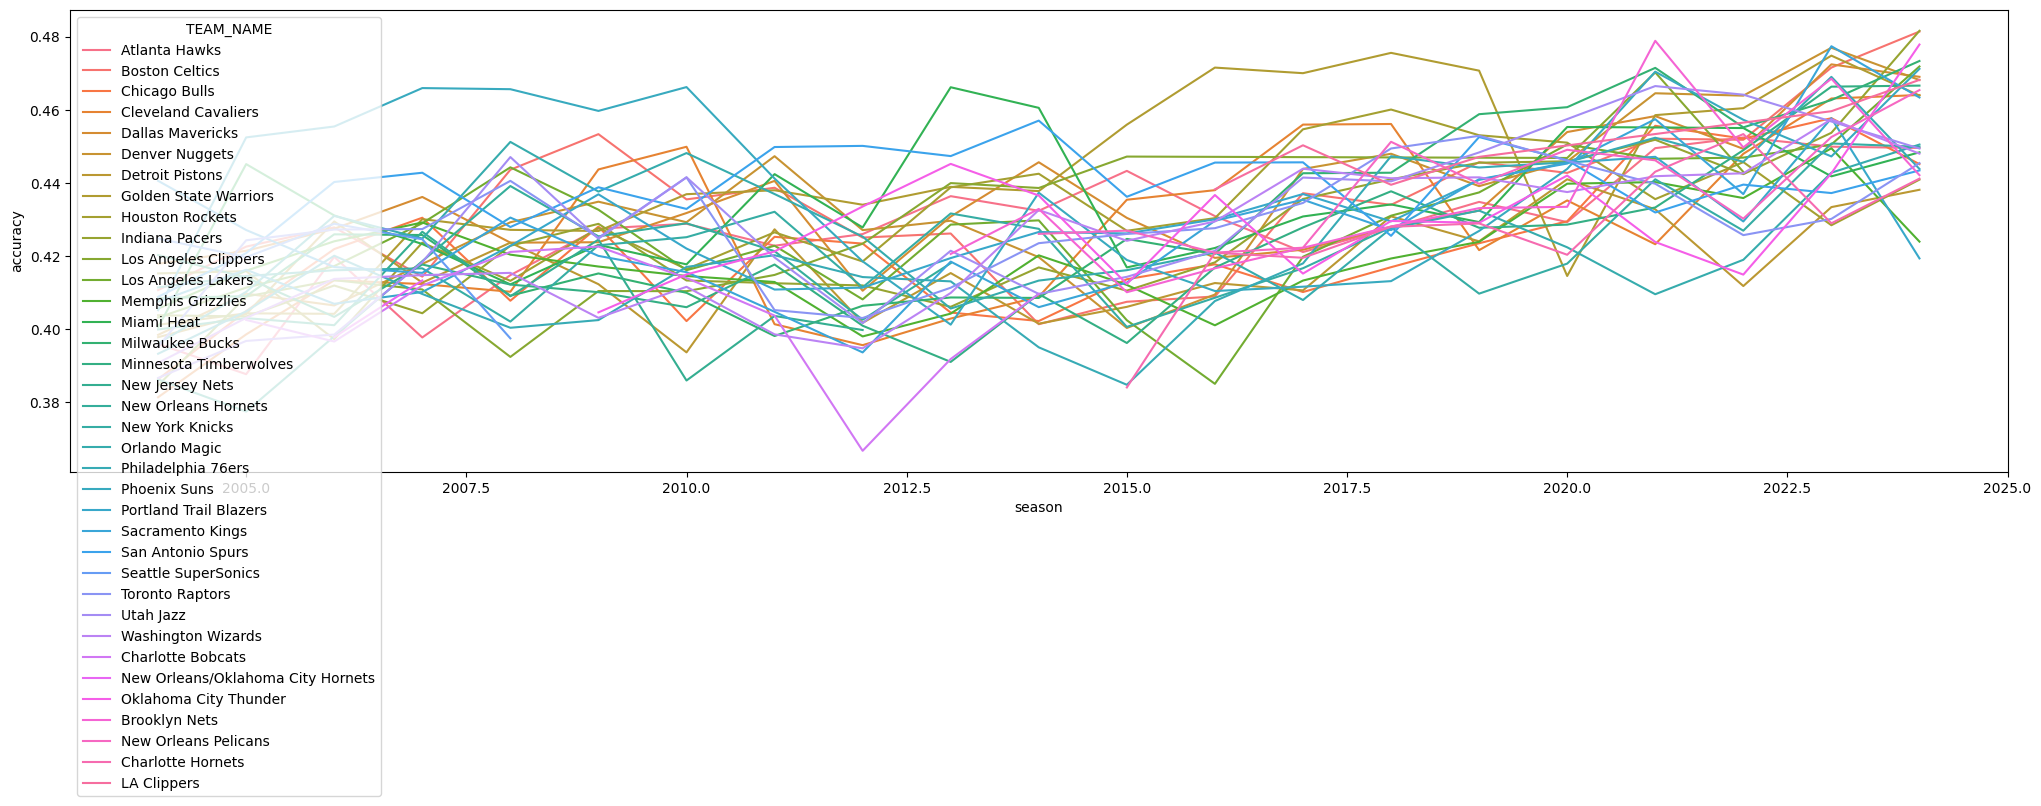

In [ ]:
#TODO: Accuracy by Team for 2pt over time with a trendline league average
plt.figure(figsize=(25,6))
sns.lineplot(data=shot_type_df, x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False, errorbar=None)
#TODO: Accuracy by Team for 3pt over time with a trendline league average



Accuracy by POSITION and BASIC_ZONE, ZONE_NAME	

In [28]:
positions_p = df_clean.POSITION.unique()
positions_sql = pd.read_sql("SELECT DISTINCT POSITION from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(positions_p) == len(positions_sql)))
positions_p

Pandas and SQL versions are identical: True


array(['SG', 'PG', 'C', 'PF', 'SF', 'SF-SG', 'C-PF', 'SG-SF', 'PG-SF',
       'SG-PG', 'PF-C', 'PF-SF', 'PG-SG', 'SF-PF', 'SG-PF', nan, 'SF-C',
       'SG-PG-SF'], dtype=object)

In [29]:
basic_zones_p = df_clean.BASIC_ZONE.unique()
basic_zones_sql = pd.read_sql("SELECT DISTINCT BASIC_ZONE from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(basic_zones_p) == len(basic_zones_sql)))
basic_zones_p

Pandas and SQL versions are identical: True


array(['Above the Break 3', 'Restricted Area', 'Mid-Range',
       'Left Corner 3', 'In The Paint (Non-RA)', 'Right Corner 3',
       'Backcourt'], dtype=object)

In [30]:
zone_names_p = df_clean.ZONE_NAME.unique()
zone_names_sql = pd.read_sql("SELECT DISTINCT ZONE_NAME from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(zone_names_p) == len(zone_names_sql)))
zone_names_p

Pandas and SQL versions are identical: True


array(['Left Side Center', 'Center', 'Left Side', 'Right Side',
       'Right Side Center', 'Back Court'], dtype=object)

In [31]:
# Query to get counts grouped by POSITION, BASIC_ZONE, ZONE_NAME
query = '''
SELECT POSITION, BASIC_ZONE, ZONE_NAME, COUNT(*) AS count
FROM nba
GROUP BY POSITION, BASIC_ZONE, ZONE_NAME
ORDER BY count DESC
'''
top_zones_df = pd.read_sql(query, conn)

# Filter to retain rows with counts in the top 25th percentile
top_zones_df = top_zones_df[top_zones_df["count"] >= top_zones_df["count"].quantile(0.75)].reset_index(drop=True)

# Filter and aggregate stats for these top combinations
position_zones_75_p = df_clean[
    df_clean.set_index(["POSITION", "BASIC_ZONE", "ZONE_NAME"]).index.isin(top_zones_df.set_index(["POSITION", "BASIC_ZONE", "ZONE_NAME"]).index)
][["POSITION", "BASIC_ZONE", "ZONE_NAME", "SHOT_MADE", "SHOT_DISTANCE"]]

# Group by POSITION, BASIC_ZONE, ZONE_NAME and aggregate
position_zones_75_p = position_zones_75_p.groupby(["POSITION", "BASIC_ZONE", "ZONE_NAME"]).agg(
    accuracy=("SHOT_MADE", "mean"),         # Average success rate (accuracy)
    avg_distance=("SHOT_DISTANCE", "mean"), # Average shot distance
    count=("SHOT_MADE", "count")            # Total number of shots
).reset_index()

position_zones_75_p

,POSITION,BASIC_ZONE,ZONE_NAME,accuracy,avg_distance,count
0,C,Above the Break 3,Center,0.349525,25.491379,18096
1,C,Above the Break 3,Left Side Center,0.337862,25.477563,14574
2,C,Above the Break 3,Right Side Center,0.338677,25.466320,13287
3,C,In The Paint (Non-RA),Center,0.429315,6.486395,129765
4,C,In The Paint (Non-RA),Left Side,0.404091,9.232200,7528
...,...,...,...,...,...,...
65,SG,Mid-Range,Left Side Center,0.396925,18.746790,38312
66,SG,Mid-Range,Right Side,0.398085,15.234395,60590
67,SG,Mid-Range,Right Side Center,0.395751,18.796367,43161
68,SG,Restricted Area,Center,0.595231,0.985434,240280


In [32]:
fig = go.Figure()
fig.update_layout(width=1400, height=800, title="NBA Players Position Accuracy, Shot Distance and Attempt Count",
                  xaxis=dict(
                      title="Average Distance from the basket",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  yaxis=dict(
                      title="Accuracy (%)",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  )
fig.add_trace(
    go.Scatter(
        x=position_zones_75_p["avg_distance"],
        y=position_zones_75_p["accuracy"] * 100,
        mode="markers",
        marker=dict(
            size=position_zones_75_p["count"],
            sizemode="area",
            sizeref=100,
            color=position_zones_75_p["count"],
            colorscale="Viridis",
            showscale=True,
            line_color='rgb(140, 140, 170)',
            colorbar_title='Shots<br>Count',
        ),
    text=position_zones_75_p["POSITION"],
    hovertemplate=(
            "Position: %{text}<br>" +
            "Accuracy: %{y:.2f}<br>" +
            "Average Distance: %{x:.2f}<br>" +
            "Attempt Count: %{marker.size:.0f}"
    ),
    name="Positions"
    )
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('Position: %{text}<br>Accuracy:' ... 'empt Count: %{marker.size:.0f}'),
              'marker': {'color': array([ 18096,  14574,  13287, 129765,   7528,   7413,   4908,  27175,  43676,
                                          17315,  37727,  16335, 324616,   5022,  36105,  49804,  46580, 121181,
                                           8674,   8330,  24910,  35146,  64843,  28023,  55720,  28249, 291476,
                                          23729,  61236,  91014,  84806, 111444,   9414,  10492,  28490,  42777,
                                          50957,  40338,  48634,  43354, 237196,  25347,  36372,  70288,  72409,
                                          81573,   6407,   6800,  43950,  26311,  53008,  25613,  53396,  30721,
                                         222773,  42448,  58650, 108737, 105600, 104354,   8271,   9499,  53008,
                                          40193,  63312,  38312,  60590,  43161, 240280,  46207], dtype=int64),
                         'colorbar': {'title': {'text': 'Shots<br>Count'}},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888888,
                                        '#b5de2b'], [1.0, '#fde725']],
                         'line': {'color': 'rgb(140, 140, 170)'},
                         'showscale': True,
                         'size': array([ 18096,  14574,  13287, 129765,   7528,   7413,   4908,  27175,  43676,
                                         17315,  37727,  16335, 324616,   5022,  36105,  49804,  46580, 121181,
                                          8674,   8330,  24910,  35146,  64843,  28023,  55720,  28249, 291476,
                                         23729,  61236,  91014,  84806, 111444,   9414,  10492,  28490,  42777,
                                         50957,  40338,  48634,  43354, 237196,  25347,  36372,  70288,  72409,
                                         81573,   6407,   6800,  43950,  26311,  53008,  25613,  53396,  30721,
                                        222773,  42448,  58650, 108737, 105600, 104354,   8271,   9499,  53008,
                                         40193,  63312,  38312,  60590,  43161, 240280,  46207], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 100},
              'mode': 'markers',
              'name': 'Positions',
              'text': array(['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
                             'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF', 'PF',
                             'PF', 'PF', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG',
                             'PG', 'PG', 'PG', 'PG', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SF',
                             'SF', 'SF', 'SF', 'SF', 'SF', 'SF', 'SG', 'SG', 'SG', 'SG', 'SG', 'SG',
                             'SG', 'SG', 'SG', 'SG', 'SG', 'SG', 'SG', 'SG'], dtype=object),
              'type': 'scatter',
              'x': array([25.49137931, 25.47756278, 25.46632046,  6.48639464,  9.23219979,
                           9.26318629, 22.80378973, 17.46973321, 13.61857771, 18.24198672,
                          13.51241816, 18.27321702,  0.86520997, 22.87873357, 25.3613073 ,
                          25.31503494, 25.26024045,  6.67563397,  9.43198063,  9.45258103,
                          22.83054998, 17.73493427, 14.45796771, 18.43250187, 14.44443647,
   

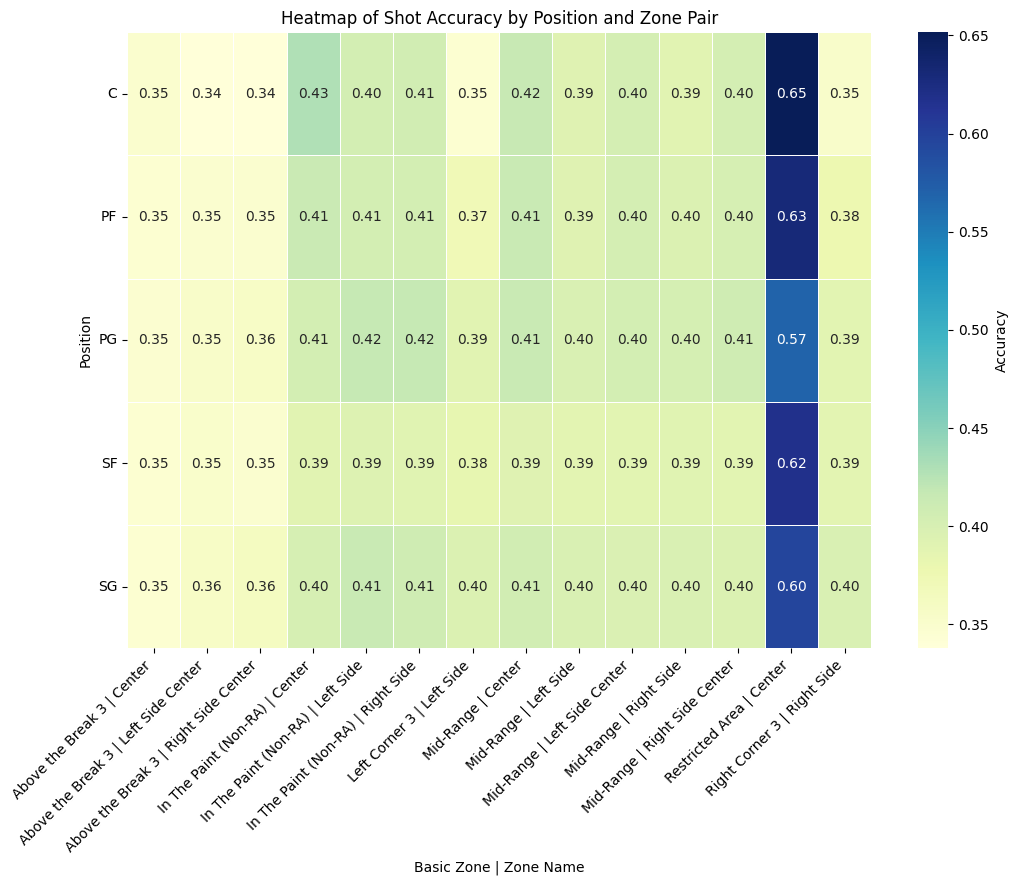

In [35]:

position_zone_pairs_75_p= position_zones_75_p
position_zone_pairs_75_p['Zone_Pair'] = position_zones_75_p['BASIC_ZONE'] + " | " + position_zones_75_p['ZONE_NAME']


pivot_data = position_zone_pairs_75_p.pivot_table(
    index='POSITION',
    columns='Zone_Pair',
    values='accuracy'
)

# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'}, linewidths=.5)
plt.title('Heatmap of Shot Accuracy by Position and Zone Pair')
plt.xlabel('Basic Zone | Zone Name')
plt.ylabel('Position')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Predictive Models
- Shot success and accuracy prediction model
- Players synergy and selection model ? 

In [ ]:
conn.close()

PCA, K-Means clustering, Linear Regression, Decision Tree